# Time Series Forecasting Case Study on Retail Gaint Sales 

First we will import required libraries and also, ignore warnings

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

#### Reading and Checking Data

In [2]:
global_data = pd.read_csv('Global+Superstore+Data.csv')

In [3]:
global_data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [4]:
global_data.shape

(51290, 5)

In [5]:
global_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [6]:
global_data.describe()

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
max,22638.480000,8399.976000


After checking the data, We create a 'Market-Segment' Column by combining the Market and Segment columns.

There are 7 Markets and 3 Segments in the data and combined, they will 21 Market Segments

In [7]:
global_data['Market-Segments'] = global_data['Market']+'-'+global_data['Segment']
global_data.head()

,Order Date,Segment,Market,Sales,Profit,Market-Segments
0,31-07-2012,Consumer,US,2309.650,762.1845,US-Consumer
1,05-02-2013,Corporate,APAC,3709.395,-288.7650,APAC-Corporate
2,17-10-2013,Consumer,APAC,5175.171,919.9710,APAC-Consumer
3,28-01-2013,Home Office,EU,2892.510,-96.5400,EU-Home Office
4,05-11-2013,Consumer,Africa,2832.960,311.5200,Africa-Consumer


Next, we convert the the 'Order Date' to year-month format

In [8]:
global_data['Order Date'] = pd.to_datetime(global_data['Order Date']).dt.to_period("m")

In [9]:
global_data.head()

,Order Date,Segment,Market,Sales,Profit,Market-Segments
0,2012-07,Consumer,US,2309.650,762.1845,US-Consumer
1,2013-05,Corporate,APAC,3709.395,-288.7650,APAC-Corporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APAC-Consumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EU-Home Office
4,2013-05,Consumer,Africa,2832.960,311.5200,Africa-Consumer


Next, to get the profit month wise and for each Market Segment, we use a Pivot Tableto get those details.

In [10]:
global_data_agg = global_data.pivot_table(index="Order Date",columns='Market-Segments',values='Profit',aggfunc='sum')
global_data_agg.head()

Market-Segments,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


Next, we perform Train- Test Split to divide and prepare the data for calculating COV.

In [11]:
train_len = 42
train_dataagg = global_data_agg[0:train_len]
test_dataagg = global_data_agg[train_len:]

In [12]:
train_dataagg.shape

(42, 21)

In [13]:
test_dataagg.shape

(6, 21)

#### Calculating COV

In [14]:
cov = pd.DataFrame(columns=['segment','cov'])
cov.head()

,segment,cov


##### Coefficient of variation is equal to the Standard Deviation, divided by the Mean.

Coefficient of Variance helps in finding the Most Consistent Profitable Market

The lower the COV the more consistent the Profit.

In [15]:
for  i in train_dataagg.columns:
    temp = {'segment':i,'cov':np.std(train_dataagg[i])/np.mean(train_dataagg[i])}
    cov = cov.append(temp,ignore_index=True)

In [16]:
cov

,segment,cov
0,APAC-Consumer,0.522725
1,APAC-Corporate,0.530051
2,APAC-Home Office,1.008219
3,Africa-Consumer,1.310351
4,Africa-Corporate,1.891744
5,Africa-Home Office,2.012937
6,Canada-Consumer,1.250315
7,Canada-Corporate,1.786025
8,Canada-Home Office,2.369695
9,EMEA-Consumer,2.652495


In [17]:
cov.sort_values(by = "cov")

,segment,cov
0,APAC-Consumer,0.522725
1,APAC-Corporate,0.530051
12,EU-Consumer,0.595215
15,LATAM-Consumer,0.683770
13,EU-Corporate,0.722076
16,LATAM-Corporate,0.882177
14,EU-Home Office,0.938072
2,APAC-Home Office,1.008219
18,US-Consumer,1.010530
19,US-Corporate,1.071829


We have found out that the most Consistent Market Segment is the 'APAC-Consumer' Segment.

Next, we extract the APAC Consumer data from the whole data.

In [18]:
APAC_Cons_data = global_data[global_data['Market-Segments']=='APAC-Consumer']

In [19]:
APAC_Cons_data.head()

,Order Date,Segment,Market,Sales,Profit,Market-Segments
2,2013-10,Consumer,APAC,5175.171,919.971,APAC-Consumer
6,2011-07,Consumer,APAC,1822.080,564.840,APAC-Consumer
7,2012-04,Consumer,APAC,5244.840,996.480,APAC-Consumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APAC-Consumer
29,2012-02,Consumer,APAC,1878.720,582.360,APAC-Consumer


In [20]:
APAC_Cons_data.shape

(5699, 6)

In [21]:
APAC_Cons_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5699 entries, 2 to 51252
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   Order Date       5699 non-null   period[M]
 1   Segment          5699 non-null   object   
 2   Market           5699 non-null   object   
 3   Sales            5699 non-null   float64  
 4   Profit           5699 non-null   float64  
 5   Market-Segments  5699 non-null   object   
dtypes: float64(2), object(3), period[M](1)
memory usage: 311.7+ KB


In [22]:
APAC_Cons_data2 = APAC_Cons_data[['Order Date','Sales']]
APAC_Cons_data2.head()

,Order Date,Sales
2,2013-10,5175.171
6,2011-07,1822.080
7,2012-04,5244.840
14,2013-06,3701.520
29,2012-02,1878.720


Next, we group the data by Month.

In [23]:
APAC_Cons_data2 = APAC_Cons_data2.groupby(['Order Date']).sum()

Next, by using the to_timestamp() function, we change the date to year-month-date format which helps in the Model Building.

In [24]:
APAC_Cons_data2 = APAC_Cons_data2.to_timestamp()

In [25]:
APAC_Cons_data2.head()

,Sales
Order Date,
2011-01-01,18821.9898
2011-02-01,23313.3531
2011-03-01,26518.4919
2011-04-01,12046.0923
2011-05-01,25941.9000


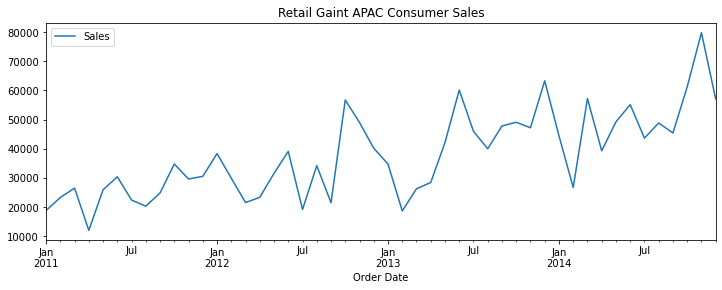

In [26]:
APAC_Cons_data2.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Gaint APAC Consumer Sales')
plt.show(block=False)

Next, we split the data into Train and Test

In [27]:
train_len = 42
train = APAC_Cons_data2[0:train_len]
test = APAC_Cons_data2[train_len:]

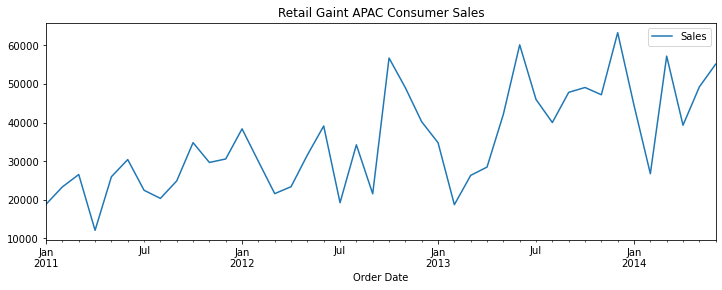

In [28]:
train.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Gaint APAC Consumer Sales')
plt.show(block=False)

##### Additive Seasonal Decomposition

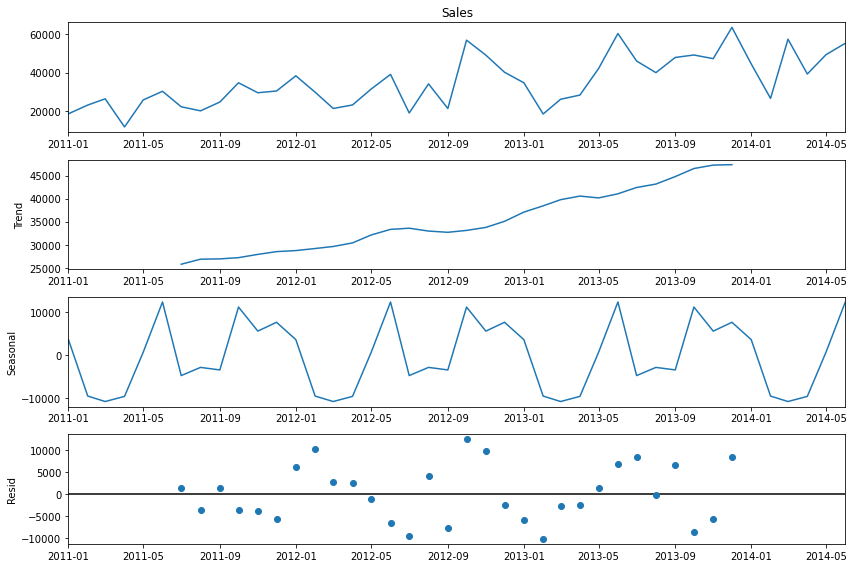

In [29]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='additive')
fig = decomposition.plot()
plt.show()

#### Multiplicative Seasonal Decomposition

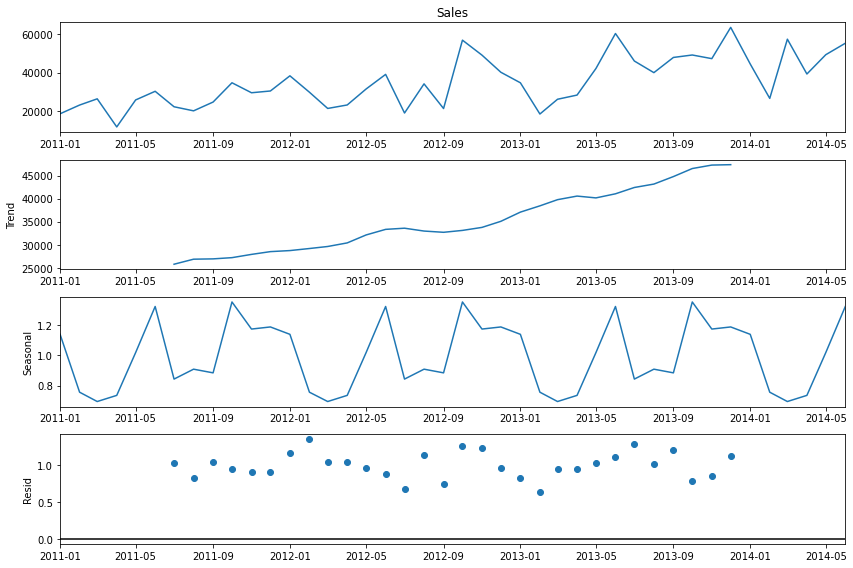

In [30]:
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## Model Building and Forecasting

#### Naive Method

In [31]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1]

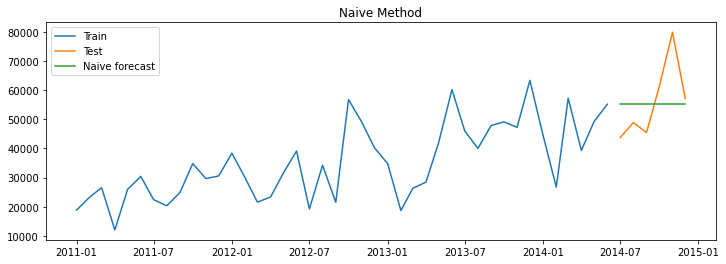

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

We can see that, forecast is same as the last point, we have in the train data.

#### Calculate RMSE and MAPE

In [33]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47


#### Simple average method

In [34]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()

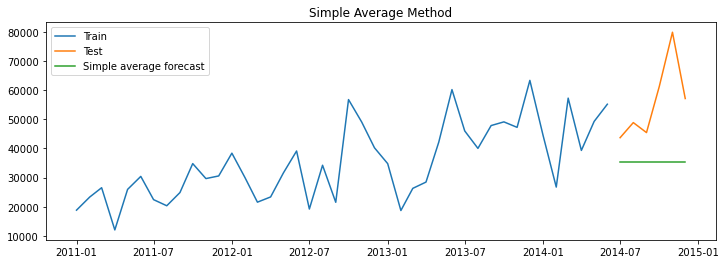

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

Here, the forecast is Average of the Sales.

In [36]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34


#### Simple moving average method

In [37]:
y_hat_sma = APAC_Cons_data2.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = APAC_Cons_data2['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

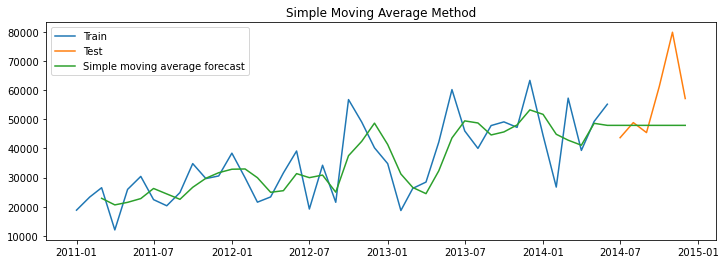

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

Here, the forecast is the average of the last few months and I have considered the last 3 Months.

In [39]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82


#### Exponential smoothing methods

#### Simple Exponential Smoothing

In [40]:
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

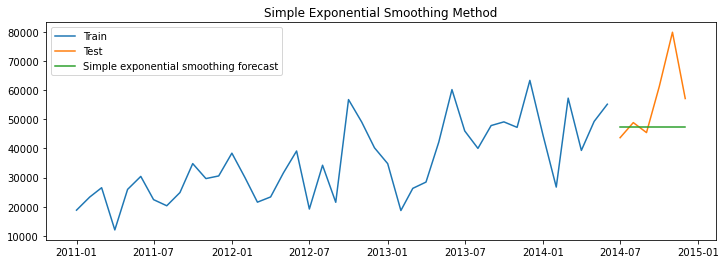

In [41]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

Here, we take the most recent months Sales and multiply it by a smoothing factor

In [42]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99


#### Holt's method with trend

In [43]:
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 18821.9898, 'initial_trend': 4491.363300000001, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


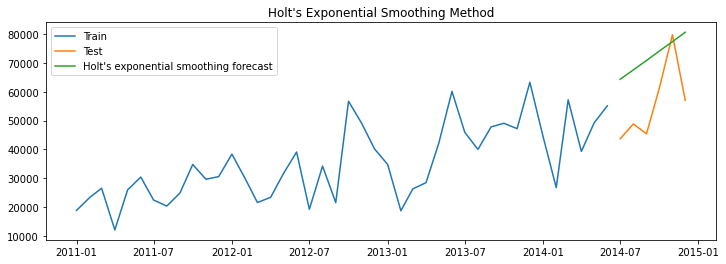

In [44]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

Here, the forecast captures Level and Trend.

In [45]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57


#### Holt Winters' additive method with trend and seasonality

In [46]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.07570161375621302, 'smoothing_trend': 0.010812706273785031, 'smoothing_seasonal': 0.10268263228517635, 'damping_trend': nan, 'initial_level': 34102.51403585773, 'initial_trend': 627.5980523821329, 'initial_seasons': array([-15283.12174868, -10806.9097142 ,  -7597.31497467, -22062.63969954,
        -8170.14182   ,  -3709.0988033 , -11681.8447568 , -13779.08847052,
        -9254.46937208,    676.71909654,  -4462.6159807 ,  -3555.20416798]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


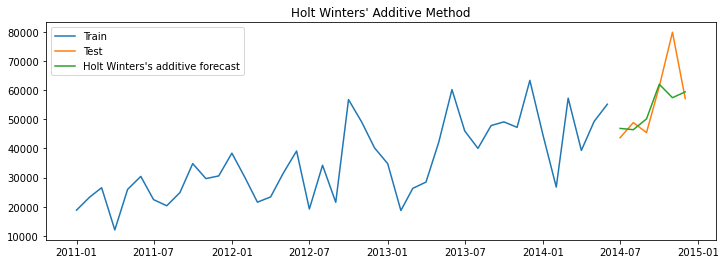

In [47]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

Here, the forecast is near to the test set, which captures Seasonality and Trend.

In [48]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33


#### Holt Winter's multiplicative method with trend and seasonality

In [49]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 34110.965325000005, 'initial_trend': 730.4167145833334, 'initial_seasons': array([0.55178708, 0.68345627, 0.77741839, 0.35314428, 0.76051498,
       0.8911777 , 0.65760657, 0.5960275 , 0.72880948, 1.01982714,
       0.86917372, 0.89574895]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


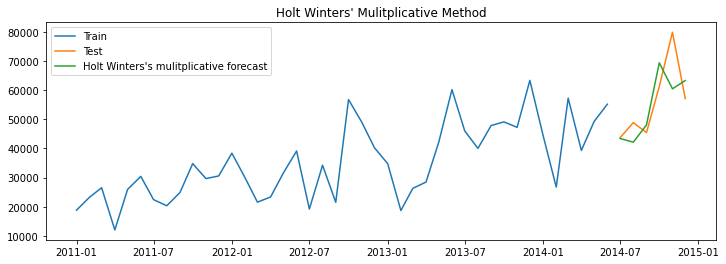

In [50]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

Here also, the forecast is near to the test set, which captures Seasonality and Trend.

In [51]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43


Here, we can observe that 'Holt Winters' additive method' is the better method for forecast as it one of the lease RMSE and MAPE Values.

## Auto Regressive methods

In an autoregressive model, the regression technique is used to formulate a time series problem. In order to implement autoregressive models, we forecast future observations using a linear combination of past observations of the same variable

#### Stationarity vs non-stationary time series

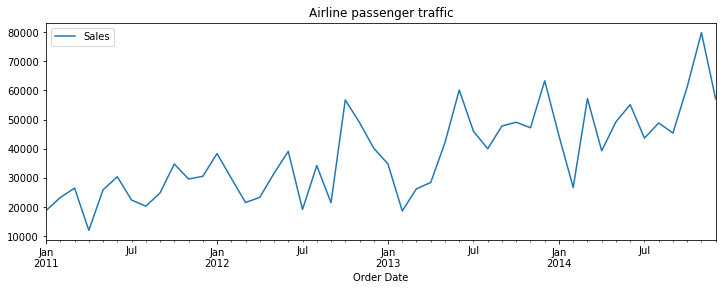

In [52]:
APAC_Cons_data2['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

#### Augmented Dickey-Fuller (ADF) test

In [53]:
adf_test = adfuller(APAC_Cons_data2['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.376024
Critical Values @ 0.05: -2.93
p-value: 0.011804


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [54]:
kpss_test = kpss(APAC_Cons_data2['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.577076
Critical Values @ 0.05: 0.46
p-value: 0.024720


#### Box Cox transformation to make variance constant

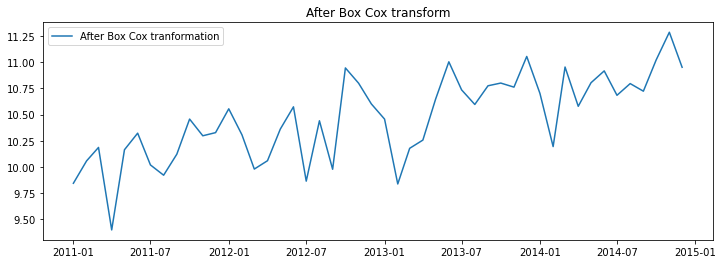

In [55]:
data_boxcox = pd.Series(boxcox(APAC_Cons_data2['Sales'], lmbda=0), index = APAC_Cons_data2.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

#### Differencing to remove trend

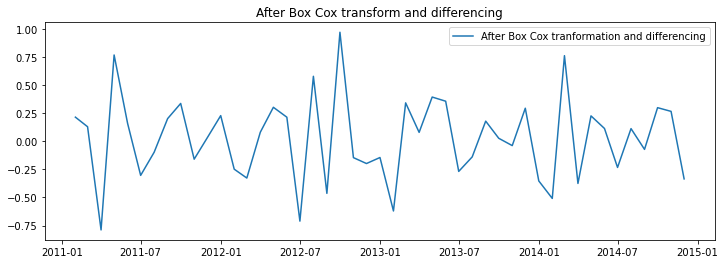

In [56]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), APAC_Cons_data2.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [57]:
data_boxcox_diff.dropna(inplace=True)

In [58]:
data_boxcox_diff.tail()

Order Date
2014-08-01    0.112012
2014-09-01   -0.072673
2014-10-01    0.298459
2014-11-01    0.265449
2014-12-01   -0.335151
Freq: MS, dtype: float64

#### Augmented Dickey-Fuller (ADF) test

In [59]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [60]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.156456
Critical Values @ 0.05: 0.46
p-value: 0.100000


#### Train Test Data Split

In [61]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [62]:
train_data_boxcox_diff

Order Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
2011-06-01    0.158548
2011-07-01   -0.303937
2011-08-01   -0.098320
2011-09-01    0.201126
2011-10-01    0.335976
2011-11-01   -0.159845
2011-12-01    0.030117
2012-01-01    0.227734
2012-02-01   -0.248683
2012-03-01   -0.327663
2012-04-01    0.079944
2012-05-01    0.301872
2012-06-01    0.213622
2012-07-01   -0.710884
2012-08-01    0.577494
2012-09-01   -0.463894
2012-10-01    0.969434
2012-11-01   -0.146063
2012-12-01   -0.198531
2013-01-01   -0.144942
2013-02-01   -0.620558
2013-03-01    0.341112
2013-04-01    0.078691
2013-05-01    0.392955
2013-06-01    0.355907
2013-07-01   -0.268628
2013-08-01   -0.139388
2013-09-01    0.178702
2013-10-01    0.026014
2013-11-01   -0.038982
2013-12-01    0.293485
2014-01-01   -0.353341
2014-02-01   -0.508883
2014-03-01    0.761118
2014-04-01   -0.375717
2014-05-01    0.225410
2014-06-01    0.113222
Freq: MS, dtype: float64

We can directly use p=1, q=1 and d=1 as the forecasts are relatively better for these values

#### Auto regression method (AR)

In [63]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


##### Recover original time series

In [64]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

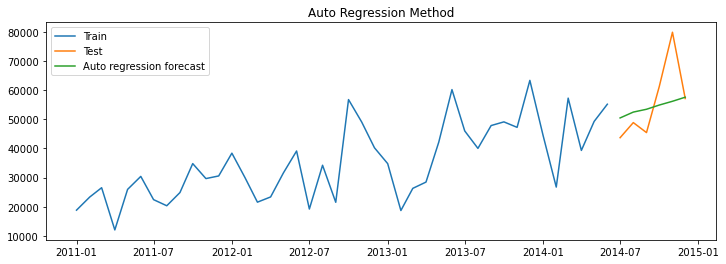

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

We Captured Trend but not Seasonality

In [66]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56


#### Moving average method (MA)

In [67]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


##### Recover original time series

In [68]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

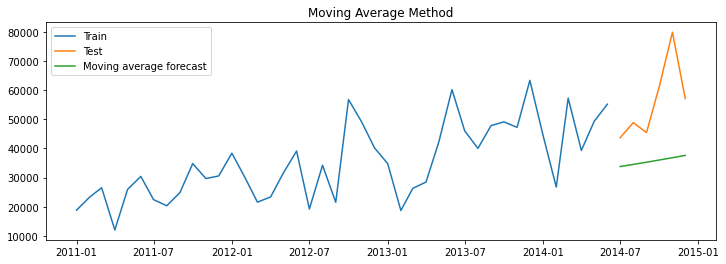

In [69]:
plt.figure(figsize=(12,4))
plt.plot(APAC_Cons_data2['Sales'][:train_len], label='Train')
plt.plot(APAC_Cons_data2['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

Here also, we Captured Trend but not Seasonality

In [70]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93


#### Auto regression moving average method (ARMA)

In [71]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


##### Recover original time series

In [72]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

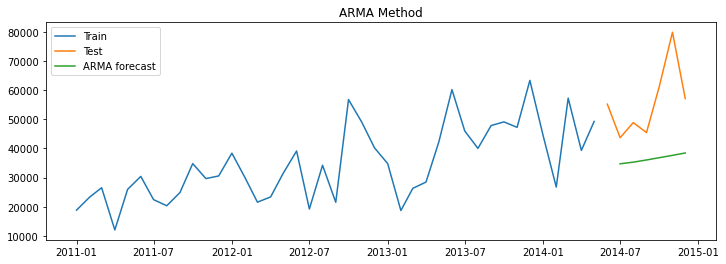

In [73]:
plt.figure(figsize=(12,4))
plt.plot(APAC_Cons_data2['Sales'][:train_len-1], label='Train')
plt.plot(APAC_Cons_data2['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

Here also, we Captured Trend but not Seasonality

In [74]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


#### Auto regressive integrated moving average (ARIMA)

In [75]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


##### Recover original time series

In [76]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

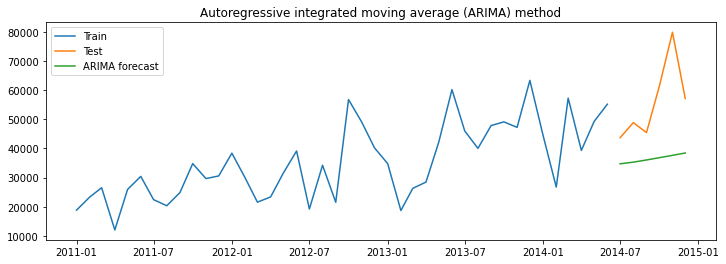

In [77]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

Here also, we Captured Trend but not Seasonality

In [78]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


#### Seasonal auto regressive integrated moving average (SARIMA)

In [79]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.041851
ma.L1      -0.996000
ar.S.L12    0.099125
ma.S.L12   -0.957885
sigma2      0.059078
dtype: float64


##### Recover original time series

In [80]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

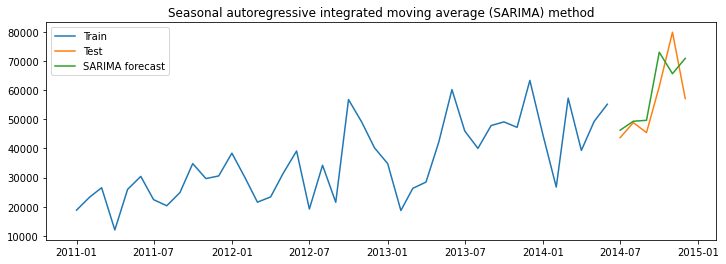

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

Here, we captured both Trend and Seasonality.

In [82]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,15011.49,15.99
0,Holt's exponential smoothing method,18976.37,34.57
0,Holt Winters' additive method,9555.63,9.33
0,Holt Winters' multiplicative method,9423.23,11.43
0,Autoregressive (AR) method,10985.28,13.56
0,Moving Average (MA) method,23360.02,33.93
0,Autoregressive moving average (ARMA) method,22654.32,32.40


We observe that, SARIMA has lease RMSE and MAPE values in Auto Regression methods and in this case, this is the best method for Forecasting.

Finally, we conclude that,  'Holt Winters' additive method' is the best method for forecasting in Smoothing Techniques and 'Seasonal auto regressive integrated moving average (SARIMA)' is the best method for forecasting in Auto Regression Techniques.